# Simulation Project
## San Francisco fires intervention simulation

The aim of this university project is to apply the main concept trated in the simulation course, in particular  simulating fire burst and fire fighters unity intervention in San Francisco, California.
In this document we present some data analysis experiment and the final simulation.

In [1]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2
pylab.rcParams['figure.figsize'] = (20, 20)
matplotlib.rcParams['figure.figsize'] = (10,10)

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from simulation_package.exponential import  Exponential
from simulation_package.gamma import  Gamma
from simulation_package.normal import Normal
from simulation_package.discrete_events import SFFireSimulation
from scipy.stats import kstest
import scipy
import re

Populating the interactive namespace from numpy and matplotlib


The [San Francisco open data portal](https://datasf.org/) provided us the data, in particular the ["Fire Incidents"](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric) dataset contains a lot of useful variables.

In the following cell we import and clean the data. All the datetime in dataset are string, to easily manage that values we convert them in python datetime as well as "Location" that we split from string to "Latitude" and "Longitude" variables.

In [2]:
#Importing and cleaning data
def getcoordfstr(location):
    return re.findall(r"[-+]?\d*\.\d+|\d+", location)

df = pd.read_csv("SF_fire_incidents/Fire_Incidents.csv", dtype=object)
df.index = pd.to_datetime(df['Incident Date'], format= "%m/%d/%Y")

df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Close DtTm'] = pd.to_datetime(df['Close DtTm'], format= "%m/%d/%Y %I:%M:%S %p")

df['Latitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[0]) if not pd.isnull(x) else x)
df['Longitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[1]) if not pd.isnull(x) else x)

### Variables exploration and distribution fitting
In this section, as introduced before, we present the analysis that we made on data and the distribution that seems to best fit.
Particulary interesting for our purpose are the following variables: 
* Alarm DtTm
* Arrival DtTm
* Close DtTm
* Action Taken Primary
* Action Taken Secondary
* Action Taken Other
* Location (Latitude and Longitude)

We used the first three (Alarm DtTm, Arrival DtTm, Close DtTm) to understand the fire burst alarm intertime distribution

In [3]:
#calculate Alarm intertime
def calculate_intertime(df, column):
    sorted_df = df.sort_values(column)
    delta = ((sorted_df[column]-sorted_df[column].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

alarm_intertime = calculate_intertime(df, 'Alarm DtTm')

1050.7392199


(0, 10000)

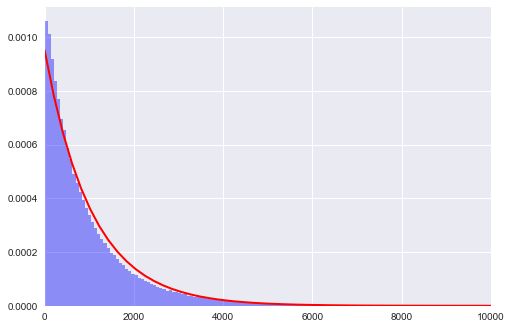

In [4]:
xs = np.linspace(0, 10000)
rv = stats.expon(0,alarm_intertime.mean())
print(alarm_intertime.mean())

f, ax = plt.subplots()
ax.hist(alarm_intertime, bins=500, color="blue", normed=True, lw=1, alpha=0.4)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)
ax.set_xlim(0, 10000)

In [ ]:
kstest(alarm_intertime, 'expon', args=(0,alarm_intertime.mean()))

In [ ]:
#calcuate serving times
def calculate_timediff(df, time_column1, time_column2):
    delta = ((df[time_column2]-df[time_column1].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

x_limit = 1000

serving_times = calculate_timediff(df, 'Arrival DtTm', 'Close DtTm')
serving_times = serving_times[(serving_times > 0)]
print(min(serving_times))
print(max(serving_times))

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    s = np.log(mean) - np.mean(np.log(data))
    shape = (3-s+np.sqrt(((s-3)**2)+24*s))/(12*s)
    scale = mean/shape
    return (shape, 0, scale)

def calculateLognormalParams(data):
    mean = np.mean(np.log(data))
    scale = np.exp(mean)
    shape = np.sqrt(np.mean((np.log(data)-mean)**2))
    return (shape, 0, scale)

print(calculateGammaParams(serving_times))

xs = np.linspace(0, x_limit)
gshape, gloc, gscale = calculateGammaParams(serving_times)

print(serving_times.mean())
rv = stats.gamma.pdf(xs, gshape, gloc, gscale)
print(serving_times.size)
plt.hist(serving_times, bins=150, color="blue", normed=True, lw=1, alpha=0.4)
plt.plot(xs, rv, color="red", lw=2)
plt.show()
plt.clf()

In [ ]:
kstest(serving_times, 'gamma', args=(gshape, gloc, gscale))

In [ ]:
intervention_times = (df['Close DtTm']-df['Alarm DtTm']).fillna(0).apply(lambda x: x.total_seconds()).astype('int64')
print(len(intervention_times))
print(len(intervention_times[intervention_times < 0.0]))

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    s = np.log(mean) - np.mean(np.log(data))
    shape = (3-s+np.sqrt(((s-3)**2)+24*s))/(12*s)
    scale = mean/shape
    return (shape, 0, scale)

def calculateGammaParams2(data):
    mean = np.mean(data)
    std = np.std(data)
    shape = (mean/std)**2
    scale = (std**2)/mean
    return (shape, 0, scale)

def calculateLognormalParams(data):
    mean = np.mean(np.log(data))
    scale = np.exp(mean)
    shape = np.sqrt(np.mean((np.log(data)-mean)**2))
    return (shape, 0, scale)

data = intervention_times[(intervention_times > 0.0) & (intervention_times < 8000.0)]
gshape, gloc, gscale = calculateGammaParams2(data)
#print(gshape, gloc, gscale)
nlshape, nlloc, nlscale = calculateLognormalParams(data)

xs = np.linspace(0, 8000)

normal_bm  = Normal(mu=nlshape, sigma=nlscale, t="bm", log=True)
pdf_bm_x, pdf_bm_y = normal_bm.pdf(30000, 150)

ey = stats.gamma.pdf(xs, gshape, gloc, gscale)
b, c = Gamma(int(round(gshape)), 1/gscale).pdf(5000, 150)
nly = stats.lognorm.pdf(xs, nlshape, nlloc, nlscale)
n, bins, patches = plt.hist(data, bins=150, normed=True, alpha=0.3)
plt.plot(xs, ey, color="red")
plt.plot(xs, nly, color="green")
plt.scatter(b,c, color="blue", alpha=0.8, s=5)
plt.scatter(pdf_bm_x, pdf_bm_y, color="black", s=5)

plt.show()
plt.clf()

In [ ]:
box = df['Box']
vc_box = box.value_counts(dropna=True)
idx = vc_box.index
x = range(len(idx))
print(len(idx))
plt.bar(x, vc_box)
plt.xticks(x, idx, rotation=90)
plt.show()

In [ ]:
normal_bm  = Normal(mu=0.0, sigma=0.25, t="bm", log=True)
pdf_bm_x, pdf_bm_y = normal_bm.pdf(30000, 150)

normal_approx = Normal(t="approx", log=False)
pdf_approx_x, pdf_approx_y = normal_approx.pdf(30000, 150)

plt.scatter(pdf_bm_x, pdf_bm_y, color="blue", s=10)
plt.scatter(pdf_approx_x, pdf_approx_y, color="green", s=10)
plt.show()

In [ ]:
civilian_fatalities = df['Number of Sprinkler Heads Operating'].value_counts(normalize=True)
print(civilian_fatalities[civilian_fatalities<300])
plt.bar(civilian_fatalities[civilian_fatalities<300].index.astype('int32'), civilian_fatalities[civilian_fatalities<300], 0.35, color='r')

In [ ]:
x = df['Action Taken Secondary'].value_counts(normalize=True)
#np.random.choice(x.index, 1, p=x)
x

In [ ]:
prop_loss = (df['Estimated Contents Loss'].dropna().astype('float'))
print(max(prop_loss))
print(min(prop_loss))

xs = np.linspace(0, 4000)
rv = stats.expon(0,prop_loss.mean())
print(prop_loss.mean())

ax = plt.subplot(111)
ax.hist(prop_loss, bins=150)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)

ax.set_ylim([0, 100])

plt.show()

In [ ]:
sprinkler = df['Number of Sprinkler Heads Operating'].dropna().astype('int64').value_counts(normalize=True)
print(sprinkler)
print(np.mean(sprinkler.index))
geom_values = pd.Series(np.random.geometric(p=(1/np.mean(sprinkler.index)), size=1000))
x = geom_values.value_counts(normalize=True)
plt.plot(sprinkler.index, sprinkler)
plt.plot(x.index, x)

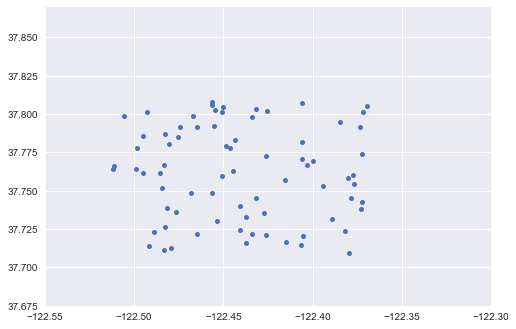

,Latitude,Longitude,Action Taken Primary,Action Taken Secondary,Action Taken Other,(A) Alarm DateTime,(D) Resolution DateTime
0,37.777782,-122.498279,86 investigate,-,-,1 day 0:8:36,1 day 0:18:18
1,37.759845,-122.450975,86 - investigate,66 - remove water,-,1 day 0:23:53,1 day 0:50:55
2,37.801251,-122.451005,86 - investigate,-,-,1 day 0:44:36,1 day 0:51:33
3,37.758193,-122.380112,86 investigate,-,-,1 day 0:49:7,1 day 0:52:12
4,37.740196,-122.440670,86 - investigate,-,-,1 day 0:49:17,1 day 0:58:28
5,37.724433,-122.440900,86 - investigate,-,-,1 day 1:10:48,1 day 1:10:55
6,37.752903,-122.394300,86 investigate,-,-,1 day 1:20:20,1 day 1:42:14
7,37.802017,-122.425639,86 - investigate,-,-,1 day 1:20:28,1 day 1:46:58
8,37.745057,-122.431667,"30 - emergency medical services, other",-,-,1 day 1:58:54,1 day 2:5:56
9,37.726617,-122.482769,86 - investigate,-,-,1 day 1:59:2,1 day 2:21:42


In [11]:
FireSimulation = SFFireSimulation(5, 1, df)
result = FireSimulation.simulate()

ax = plt.subplot(111)
ax.plot(result['Longitude'], result['Latitude'],'o', markersize=5)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

result